### Предлагаю Вам выполнить следующее тестовое задание.<br> 
Необходимо натренировать нейронную сеть, которая на вход будет принимать картинку со словом, а на выходе - определяет шрифт, которым написан текст. <br> 
Для начала возьмите порядка 10 разных шрифтов. <br> 
Датасеты для обучения и валидации Вам предлагается сгенерировать самостоятельно. <br> 
Фреймворк для обучения сети - TensorFlow, язык скриптов - Python. <br> Оформление задачи в виде Jupyter notebook приветствуется. 

<br> 
##### Выполнил: Евгений Сорока 

In [1]:
import tensorflow as tf
import numpy as np
from scipy.misc import imresize

import matplotlib.pyplot as plt
from matplotlib import rcParams
from skimage import io
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#from tqdm import tqdm

plt.style.use('ggplot')
rcParams['figure.figsize'] = 10, 8
seed = 256

%matplotlib inline

/home/eugenerodse/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Загрузим сгенированный датасет. 
Датасет включает в себя 1300 уникальных слов, каждое слово имеет 10 различных написаний, в зависимости от шрифта.
Используемые шрифты: 
<li>arial
<li>bookman
<li>calibri
<li>comic
<li>dotu
<li>georgia
<li>gost
<li>tahoma
<li>time new
<li>roma

In [2]:
directory = os.listdir('data/')

In [3]:
fonts = [os.path.join('data', d+'/') for d in os.listdir('data/')]
data_links = sorted([os.path.join(f, i) for f in fonts for i in os.listdir(f)])

In [4]:
len(data_links)

13000

In [5]:
labels = np.array([np.zeros(1300, dtype=np.int32)+i for i in range(0, 10)]).flatten()
labels.shape

(13000,)

In [6]:
data_raw = np.array([io.imread(img, as_grey=True).astype(np.float32) for img in data_links])

Преообразуем изображения к единому виду.

In [7]:
data = np.array([imresize(img, (28, 126)) for img in data_raw])
data = np.array([img[:,:-26] for img in data])

/home/eugenerodse/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


In [8]:
%store data_raw
del data_raw

Stored 'data_raw' (ndarray)


In [9]:
data.shape

(13000, 28, 100)

Посмотрим как выглядят обьекты

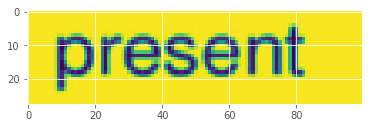

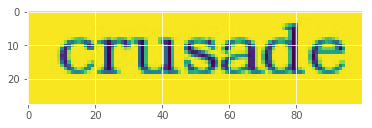

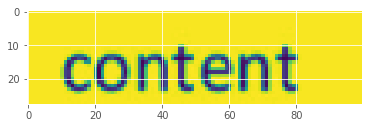

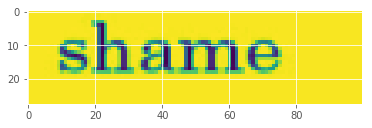

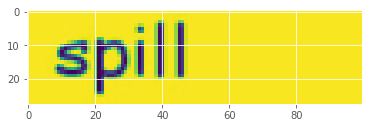

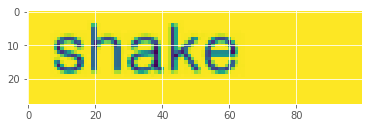

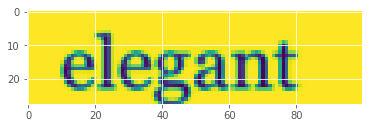

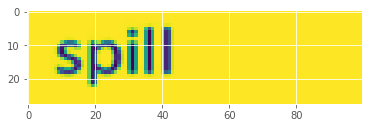

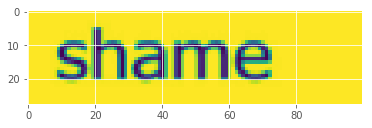

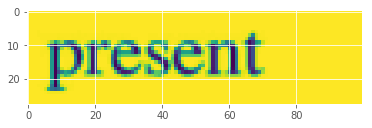

In [10]:
for i in np.linspace(0, 13000, 10, endpoint=False, dtype=np.int32):
    plt.figure()
    plt.imshow(data[i])

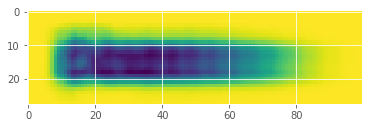

In [11]:
mean = data.mean(axis=0)
plt.imshow(mean)

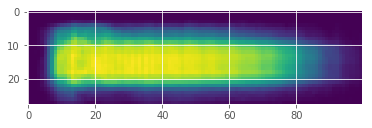

In [12]:
stddev = data.std(axis=0)
plt.imshow(stddev)

Преобразуем целевые переменные в бинарный формат

In [13]:
def onehot(y):
    a = np.zeros((y.shape[0], 10))
    a[np.arange(y.shape[0]), y] = 1
    print(a[0])
    return a

y = onehot(labels)
y.shape

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


(13000, 10)

In [14]:
train = data[:,:,:,np.newaxis] / 255
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.25, random_state=seed)
print(X_train.shape)
print(X_test.shape)
print(np.sum(y_train, axis=0))


(9750, 28, 100, 1)
(3250, 28, 100, 1)
[971. 953. 975. 994. 978. 973. 968. 978. 972. 988.]


In [15]:
%store data
del data

Stored 'data' (ndarray)


Построим модель подходом библиотеки Keras, но на Tensorflow

In [21]:
model = tf.keras.Sequential(name='CNN')
model.add(tf.keras.layers.Conv2D(32, kernel_size=(4, 4),
                                 activation='relu',
                                 input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(64, (4, 4), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2048, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 25, 97, 32)        544       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 94, 64)        32832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 47, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 11, 47, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 33088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              67766272  
_________________________________________________________________
dense_7 (Dense)              (None, 128)               262272    
__________

In [22]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [23]:
n_epochs = 12
batch_size = 256

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=n_epochs,
          verbose=1,
          validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 9750 samples, validate on 3250 samples
Epoch 1/12
9750/9750 [==============================] - 228s 23ms/step - loss: 2.0767 - acc: 0.2679 - val_loss: 1.4488 - val_acc: 0.4720
Epoch 2/12
9750/9750 [==============================] - 225s 23ms/step - loss: 1.2012 - acc: 0.5943 - val_loss: 0.8905 - val_acc: 0.6791
Epoch 3/12
9750/9750 [==============================] - 224s 23ms/step - loss: 0.7515 - acc: 0.7443 - val_loss: 0.5723 - val_acc: 0.8212
Epoch 4/12
9750/9750 [==============================] - 223s 23ms/step - loss: 0.6033 - acc: 0.8066 - val_loss: 1.4775 - val_acc: 0.5643
Epoch 5/12
9750/9750 [==============================] - 223s 23ms/step - loss: 0.3803 - acc: 0.8736 - val_loss: 0.4239 - val_acc: 0.8625
Epoch 6/12
9750/9750 [==============================] - 224s 23ms/step - loss: 0.2220 - acc: 0.9246 - val_loss: 0.5211 - val_acc: 0.7960
Epoch 7/12
9750/9750 [==============================] - 223s 23ms/step - loss: 0.1870 - acc: 0.9422 - val_loss: 0.1588 - val_acc: 

Реализация классическим методом Tensorflow

In [16]:
X = tf.placeholder(name='Input', dtype='float32', shape=[None, 28, 126, 1])
y = tf.placeholder(name='Target', dtype='int32', shape = [None, 10])

In [17]:
def conv_relu(inputs, filters, k_size, stride, padding, scope_name):
    '''
    A method that does convolution + relu on inputs
    '''
    with tf.variable_scope(scope_name, reuse=tf.AUTO_REUSE) as scope:
        num_channels = inputs.shape[-1]
        kernel = tf.get_variable(dtype=tf.float32, 
                                  shape=[k_size, k_size, num_channels, filters], 
                                  initializer = tf.contrib.layers.xavier_initializer(),
                                  name='kernel_'+ scope.name)
        
        biases = tf.get_variable(dtype=tf.float32, 
                                 shape=[filters],
                                 initializer=tf.random_normal_initializer(),
                                 name='biases_' + scope.name)
        
        conv = tf.nn.conv2d(inputs, 
                            kernel, 
                            strides=[1, stride, stride, 1], 
                            padding=padding)
        
        activation = tf.nn.relu(conv + biases, name=scope.name)
         
    return activation

#--------------------------------------------------------------------------------

def maxpool(inputs, ksize, stride, padding='VALID', scope_name='pool'):
    '''A method that does max pooling on inputs'''
    with tf.variable_scope(scope_name, reuse=tf.AUTO_REUSE) as scope:
        pool = tf.nn.max_pool(inputs, 
                              ksize=[1, ksize, ksize, 1], 
                              strides=[1,stride,stride,1],
                              padding=padding,
                              name='max_'+scope.name)
    
    return pool

#--------------------------------------------------------------------------------

def fully_connected(inputs, out_dim, scope_name='fc'):
    '''
    A fully connected linear layer on inputs
    '''
    with tf.variable_scope(scope_name, reuse=tf.AUTO_REUSE) as scope:
        #print(inputs)
        in_dim = inputs.shape[-1]
        weights = tf.get_variable(dtype=tf.float32, 
                                  initializer=tf.contrib.layers.xavier_initializer(),
                                  shape=[in_dim, out_dim],
                                  name='weights_'+scope.name)
        biases = tf.get_variable(dtype=tf.float32, 
                                 shape=[out_dim],
                                 initializer=tf.constant_initializer(0.0),
                                 name='biases_'+ scope.name)
    
        out = tf.matmul(inputs,weights) + biases
        
    return out

In [21]:
tf.reset_default_graph()

In [ ]:
learning_rate = 0.01
batch_size = 256
n_epochs = 12
n_classes = 10


X = tf.placeholder(name='Input', dtype='float32', shape=[None, 28, 100, 1])
y = tf.placeholder(name='Target', dtype='int32', shape = [None, n_classes])


conv_1 = conv_relu(scope_name='conv_1', 
                   inputs=X, 
                   filters=32, 
                   stride=1,
                   k_size=5, 
                   padding='SAME')


conv_2 = conv_relu(scope_name='conv_2', 
                   inputs=conv_1, 
                   filters=64, 
                   stride=1,
                   k_size=5, 
                   padding='SAME')


pool_1 = maxpool(scope_name='maxpool_1', 
                 inputs=conv_2, 
                 ksize=2, 
                 stride=2, 
                 padding='VALID')


dropout_1 = tf.nn.dropout(x=pool_1, keep_prob=0.4, name='dropout_1')


pool_2 = maxpool(scope_name='maxpool_2', 
                 inputs=dropout_1, 
                 ksize=2, 
                 stride=2, 
                 padding='VALID')


flatten = pool_2.shape[1] * pool_2.shape[2] * pool_2.shape[3]
pool_2 = tf.reshape(pool_2, [-1, flatten])


fc_1 = fully_connected(pool_2, out_dim=2048, scope_name='fully_connected_1')


dropout_2 = tf.nn.dropout(x=tf.nn.relu(fc_1), keep_prob=0.5, name='dropout')


logits = fully_connected(inputs=dropout_2, out_dim=n_classes, scope_name='logits_fc')



with tf.name_scope('loss'):
    entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels= y, 
                                                         logits= logits)
    loss = tf.reduce_mean(entropy, name='loss')



with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)


    
        
results = np.zeros(n_epochs)
    
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
        
        idx = np.random.permutation(range(len(X_train)))
        n_batches = len(X_train) // batch_size
        
        for batch in tqdm(range(n_batches)):
            idx_i = idx[batch * batch_size : (batch+1) * batch_size]
            sess.run(optimizer, feed_dict={X: X_train[idx_i], y: y_train[idx_i]})
            print(batch,'/',n_batches)
        loss_i = sess.run(loss, feed_dict={X: X_train, y: y_train})
        #mse = accuracy_score(y_train, sess.run(y_hat, {X:X_train}))
        results[epoch] = loss_i
        
        print('Epoch:', epoch)
        print('Loss:', loss_i)
        #print('Train accuracy:', mse)
        print('-'*30)
        
    print('Final score:', accuracy_score(y_test, sess.run(y_hat, {X: X_test})))



0 / 38
1 / 38
2 / 38
3 / 38
4 / 38
5 / 38
6 / 38
7 / 38
8 / 38
9 / 38
10 / 38
11 / 38
12 / 38
13 / 38
14 / 38
15 / 38
16 / 38
17 / 38
18 / 38
19 / 38
20 / 38
21 / 38
22 / 38
23 / 38
24 / 38
25 / 38
26 / 38
27 / 38
28 / 38
29 / 38
30 / 38
31 / 38
32 / 38
33 / 38
34 / 38
35 / 38
36 / 38
37 / 38
